In [1]:
with open('D:/work/deeplearning_with_python_env/venv/src/deeplearning_with_python_book/jena_climate_2009_2016.csv') as f:
    lines = f.read()
    
lines = lines.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [2]:
import numpy as np

data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    line_data = [float(x) for x in line.split(',')[1:]]
    data[i, :] = line_data

In [3]:
from matplotlib import pyplot as plt

temp = data[:, 1]
plt.plot(range(1, len(temp)+1), temp)

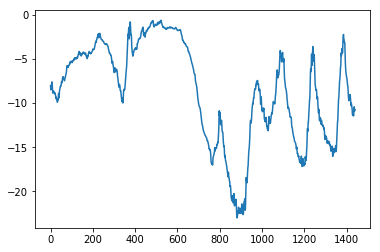

In [4]:
plt.plot(range(1440), temp[:1440])

In [5]:
mean = data[:200000].mean(axis=0)
data -= mean
std = data[:200000].std(axis=0)
data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows), 1))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets
    

In [7]:
lookback = 1440 # 10 days
step = 6
delay = 144 # 1 day
batch_size = 128

In [8]:
train_gen = generator(data, lookback=lookback, delay=delay, 
                      min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(data, lookback=lookback, delay=delay, 
                      min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)

test_gen = generator(data, lookback=lookback, delay=delay, 
                      min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

In [9]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(data) - 300001 - lookback)

In [23]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print (np.mean(batch_maes))
    
evaluate_naive_method()

KeyboardInterrupt: 

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])
                         ))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20


  1/500 [..............................] - ETA: 16:31 - loss: 1.2422

  4/500 [..............................] - ETA: 4:12 - loss: 5.4371 

  7/500 [..............................] - ETA: 2:28 - loss: 4.8547

 10/500 [..............................] - ETA: 1:45 - loss: 4.3484

 13/500 [..............................] - ETA: 1:22 - loss: 4.0413

 14/500 [..............................] - ETA: 1:21 - loss: 4.0096



 16/500 [..............................] - ETA: 1:12 - loss: 3.8326

 19/500 [>.............................] - ETA: 1:02 - loss: 3.5971

 21/500 [>.............................] - ETA: 58s - loss: 3.4808 

 23/500 [>.............................] - ETA: 54s - loss: 3.3741

 25/500 [>.............................] - ETA: 51s - loss: 3.2675

 27/500 [>.............................] - ETA: 49s - loss: 3.1707

 29/500 [>.............................] - ETA: 47s - loss: 3.1258



 30/500 [>.............................] - ETA: 47s - loss: 3.1009

 32/500 [>.............................] - ETA: 45s - loss: 3.0259

 33/500 [>.............................] - ETA: 44s - loss: 3.0074



 34/500 [=>............................] - ETA: 43s - loss: 2.9806

 36/500 [=>............................] - ETA: 42s - loss: 2.9292

 38/500 [=>............................] - ETA: 41s - loss: 2.8793



 39/500 [=>............................] - ETA: 40s - loss: 2.8501

 40/500 [=>............................] - ETA: 40s - loss: 2.8172



 41/500 [=>............................] - ETA: 40s - loss: 2.7969

 42/500 [=>............................] - ETA: 40s - loss: 2.7808

 43/500 [=>............................] - ETA: 40s - loss: 2.7595

 45/500 [=>............................] - ETA: 39s - loss: 2.7177

 46/500 [=>............................] - ETA: 39s - loss: 2.7115

 48/500 [=>............................] - ETA: 38s - loss: 2.6860



 49/500 [=>............................] - ETA: 37s - loss: 2.6674

 50/500 [==>...........................] - ETA: 37s - loss: 2.6493



 52/500 [==>...........................] - ETA: 36s - loss: 2.6213



 53/500 [==>...........................] - ETA: 36s - loss: 2.6064

 55/500 [==>...........................] - ETA: 35s - loss: 2.5753



 57/500 [==>...........................] - ETA: 34s - loss: 2.5398

 59/500 [==>...........................] - ETA: 34s - loss: 2.5177

 61/500 [==>...........................] - ETA: 33s - loss: 2.4792

 63/500 [==>...........................] - ETA: 32s - loss: 2.4543

 65/500 [==>...........................] - ETA: 32s - loss: 2.4409

 67/500 [===>..........................] - ETA: 31s - loss: 2.4326



 69/500 [===>..........................] - ETA: 30s - loss: 2.4099



 71/500 [===>..........................] - ETA: 30s - loss: 2.3962

 73/500 [===>..........................] - ETA: 29s - loss: 2.3841



 75/500 [===>..........................] - ETA: 28s - loss: 2.3696

 77/500 [===>..........................] - ETA: 28s - loss: 2.3526

 79/500 [===>..........................] - ETA: 27s - loss: 2.3336

 80/500 [===>..........................] - ETA: 27s - loss: 2.3231

 82/500 [===>..........................] - ETA: 27s - loss: 2.3021

 84/500 [====>.........................] - ETA: 27s - loss: 2.2840

 86/500 [====>.........................] - ETA: 26s - loss: 2.2764



 88/500 [====>.........................] - ETA: 26s - loss: 2.2598



 90/500 [====>.........................] - ETA: 25s - loss: 2.2500

 92/500 [====>.........................] - ETA: 25s - loss: 2.2355

 94/500 [====>.........................] - ETA: 25s - loss: 2.2208

 96/500 [====>.........................] - ETA: 24s - loss: 2.2069

 98/500 [====>.........................] - ETA: 24s - loss: 2.1974



100/500 [=====>........................] - ETA: 23s - loss: 2.1902

101/500 [=====>........................] - ETA: 23s - loss: 2.1848



104/500 [=====>........................] - ETA: 23s - loss: 2.1710

106/500 [=====>........................] - ETA: 23s - loss: 2.1560

108/500 [=====>........................] - ETA: 22s - loss: 2.1444

110/500 [=====>........................] - ETA: 22s - loss: 2.1325



112/500 [=====>........................] - ETA: 22s - loss: 2.1208



113/500 [=====>........................] - ETA: 22s - loss: 2.1174



115/500 [=====>........................] - ETA: 21s - loss: 2.1114

117/500 [======>.......................] - ETA: 21s - loss: 2.0983



119/500 [======>.......................] - ETA: 21s - loss: 2.0906



121/500 [======>.......................] - ETA: 21s - loss: 2.0799

123/500 [======>.......................] - ETA: 20s - loss: 2.0749

125/500 [======>.......................] - ETA: 20s - loss: 2.0631



127/500 [======>.......................] - ETA: 20s - loss: 2.0537

129/500 [======>.......................] - ETA: 20s - loss: 2.0446

131/500 [======>.......................] - ETA: 19s - loss: 2.0390



134/500 [=======>......................] - ETA: 19s - loss: 2.0250

136/500 [=======>......................] - ETA: 19s - loss: 2.0227

138/500 [=======>......................] - ETA: 19s - loss: 2.0165

140/500 [=======>......................] - ETA: 18s - loss: 2.0077



142/500 [=======>......................] - ETA: 18s - loss: 1.9992

144/500 [=======>......................] - ETA: 18s - loss: 1.9915

147/500 [=======>......................] - ETA: 18s - loss: 1.9786

149/500 [=======>......................] - ETA: 17s - loss: 1.9703



151/500 [========>.....................] - ETA: 17s - loss: 1.9662



153/500 [========>.....................] - ETA: 17s - loss: 1.9622

155/500 [========>.....................] - ETA: 17s - loss: 1.9571

157/500 [========>.....................] - ETA: 17s - loss: 1.9480



159/500 [========>.....................] - ETA: 17s - loss: 1.9401

161/500 [========>.....................]

 - ETA: 16s - loss: 1.9332



163/500 [========>.....................] - ETA: 16s - loss: 1.9255

165/500 [========>.....................] - ETA: 16s - loss: 1.9197



167/500 [=========>....................] - ETA: 16s - loss: 1.9132

169/500 [=========>....................] - ETA: 16s - loss: 1.9056



171/500 [=========>....................] - ETA: 16s - loss: 1.8991

173/500 [=========>....................] - ETA: 15s - loss: 1.8961



175/500 [=========>....................] - ETA: 15s - loss: 1.8895

177/500 [=========>....................] - ETA: 15s - loss: 1.8856

179/500 [=========>....................] - ETA: 15s - loss: 1.8789



181/500 [=========>....................] - ETA: 15s - loss: 1.8712



183/500 [=========>....................] - ETA: 15s - loss: 1.8637



185/500 [==========>...................] - ETA: 14s - loss: 1.8568

187/500 [==========>...................] - ETA: 14s - loss: 1.8508



189/500 [==========>...................] - ETA: 14s - loss: 1.8470

191/500 [==========>...................] - ETA: 14s - loss: 1.8445



193/500 [==========>...................] - ETA: 14s - loss: 1.8396



195/500 [==========>...................] - ETA: 14s - loss: 1.8318



197/500 [==========>...................] - ETA: 14s - loss: 1.8250



199/500 [==========>...................] - ETA: 13s - loss: 1.8233



201/500 [===========>..................] - ETA: 13s - loss: 1.8177

203/500 [===========>..................] - ETA: 13s - loss: 1.8129



205/500 [===========>..................] - ETA: 13s - loss: 1.8091



207/500 [===========>..................] - ETA: 13s - loss: 1.8027



209/500 [===========>..................] - ETA: 13s - loss: 1.7986

211/500 [===========>..................] - ETA: 13s - loss: 1.7934

213/500 [===========>..................] - ETA: 13s - loss: 1.7898



215/500 [===========>..................] - ETA: 12s - loss: 1.7860



217/500 [============>.................] - ETA: 12s - loss: 1.7800



219/500 [============>.................] - ETA: 12s - loss: 1.7742



221/500 [============>.................] - ETA: 12s - loss: 1.7722



223/500 [============>.................] - ETA: 12s - loss: 1.7683



225/500 [============>.................] - ETA: 12s - loss: 1.7644

226/500 [============>.................] - ETA: 12s - loss: 1.7627



228/500 [============>.................] - ETA: 12s - loss: 1.7570



230/500 [============>.................] - ETA: 12s - loss: 1.7525

232/500 [============>.................] - ETA: 11s - loss: 1.7489



234/500 [=============>................] - ETA: 11s - loss: 1.7433



236/500 [=============>................] - ETA: 11s - loss: 1.7379



238/500 [=============>................] - ETA: 11s - loss: 1.7351



240/500 [=============>................] - ETA: 11s - loss: 1.7325

242/500 [=============>................] - ETA: 11s - loss: 1.7273

244/500 [=============>................] - ETA: 11s - loss: 1.7238



246/500 [=============>................] - ETA: 11s - loss: 1.7187



248/500 [=============>................] - ETA: 10s - loss: 1.7131

250/500 [==============>...............] - ETA: 10s - loss: 1.7078



252/500 [==============>...............] - ETA: 10s - loss: 1.7058



254/500 [==============>...............] - ETA: 10s - loss: 1.7045



256/500 [==============>...............] - ETA: 10s - loss: 1.7009

258/500 [==============>...............] - ETA: 10s - loss: 1.6962

261/500 [==============>...............] - ETA: 10s - loss: 1.6880

263/500 [==============>...............] - ETA: 10s - loss: 1.6851



266/500 [==============>...............] - ETA: 9s - loss: 1.6824 



268/500 [===============>..............] - ETA: 9s - loss: 1.6779



270/500 [===============>..............] - ETA: 9s - loss: 1.6750

272/500 [===============>..............] - ETA: 9s - loss: 1.6726



274/500 [===============>..............] - ETA: 9s - loss: 1.6690



276/500 [===============>..............] - ETA: 9s - loss: 1.6638

278/500 [===============>..............] - ETA: 9s - loss: 1.6581



281/500 [===============>..............] - ETA: 9s - loss: 1.6527

283/500 [===============>..............] - ETA: 9s - loss: 1.6510



286/500 [================>.............] - ETA: 8s - loss: 1.6460

288/500 [================>.............] - ETA: 8s - loss: 1.6437



291/500 [================>.............] - ETA: 8s - loss: 1.6387



293/500 [================>.............] - ETA: 8s - loss: 1.6341



295/500 [================>.............] - ETA: 8s - loss: 1.6299

297/500 [================>.............] - ETA: 8s - loss: 1.6266



300/500 [=================>............] - ETA: 8s - loss: 1.6197



302/500 [=================>............] - ETA: 8s - loss: 1.6161

304/500 [=================>............] - ETA: 7s - loss: 1.6145

307/500 [=================>............] - ETA: 7s - loss: 1.6111



310/500 [=================>............] - ETA: 7s - loss: 1.6054



311/500 [=================>............] - ETA: 7s - loss: 1.6031

313/500 [=================>............] - ETA: 7s - loss: 1.6002

316/500 [=================>............] - ETA: 7s - loss: 1.5944



319/500 [==================>...........] - ETA: 7s - loss: 1.5896

321/500 [==================>...........] - ETA: 7s - loss: 1.5877



324/500 [==================>...........] - ETA: 6s - loss: 1.5833

326/500 [==================>...........] - ETA: 6s - loss: 1.5812



329/500 [==================>...........] - ETA: 6s - loss: 1.5758

331/500 [==================>...........] - ETA: 6s - loss: 1.5724



334/500 [===================>..........] - ETA: 6s - loss: 1.5693

336/500 [===================>..........] - ETA: 6s - loss: 1.5661

338/500 [===================>..........] - ETA: 6s - loss: 1.5628



341/500 [===================>..........] - ETA: 6s - loss: 1.5579

343/500 [===================>..........] - ETA: 6s - loss: 1.5551

346/500 [===================>..........] - ETA: 5s - loss: 1.5511



349/500 [===================>..........] - ETA: 5s - loss: 1.5459



351/500 [====================>.........] - ETA: 5s - loss: 1.5427

353/500 [====================>.........] - ETA: 5s - loss: 1.5382

356/500 [====================>.........] - ETA: 5s - loss: 1.5326

358/500 [====================>.........] - ETA: 5s - loss: 1.5323

361/500 [====================>.........] - ETA: 5s - loss: 1.5291



364/500 [====================>.........] - ETA: 5s - loss: 1.5248



366/500 [====================>.........] - ETA: 5s - loss: 1.5216



368/500 [=====================>........] - ETA: 5s - loss: 1.5175

371/500 [=====================>........] - ETA: 4s - loss: 1.5145

374/500 [=====================>........] - ETA: 4s - loss: 1.5108



376/500 [=====================>........] - ETA: 4s - loss: 1.5070

378/500 [=====================>........] - ETA: 4s - loss: 1.5047

381/500 [=====================>........] - ETA: 4s - loss: 1.5010



384/500 [======================>.......] - ETA: 4s - loss: 1.4983

387/500 [======================>.......] - ETA: 4s - loss: 1.4936



389/500 [======================>.......] - ETA: 4s - loss: 1.4908

391/500 [======================>.......] - ETA: 4s - loss: 1.4881

394/500 [======================>.......] - ETA: 3s - loss: 1.4851



397/500 [======================>.......] - ETA: 3s - loss: 1.4827

399/500 [======================>.......] - ETA: 3s - loss: 1.4791



402/500 [=======================>......] - ETA: 3s - loss: 1.4759



404/500 [=======================>......] - ETA: 3s - loss: 1.4734



406/500 [=======================>......] - ETA: 3s - loss: 1.4711

408/500 [=======================>......] - ETA: 3s - loss: 1.4676

411/500 [=======================>......] - ETA: 3s - loss: 1.4631



414/500 [=======================>......] - ETA: 3s - loss: 1.4599



416/500 [=======================>......] - ETA: 3s - loss: 1.4573



418/500 [========================>.....] - ETA: 2s - loss: 1.4556

421/500 [========================>.....] - ETA: 2s - loss: 1.4528



423/500 [========================>.....] - ETA: 2s - loss: 1.4506



425/500 [========================>.....] - ETA: 2s - loss: 1.4480

428/500 [========================>.....] - ETA: 2s - loss: 1.4437



431/500 [========================>.....] - ETA: 2s - loss: 1.4411

433/500 [========================>.....] - ETA: 2s - loss: 1.4383



436/500 [=========================>....] - ETA: 2s - loss: 1.4335



438/500 [=========================>....] - ETA: 2s - loss: 1.4303

441/500 [=========================>....] - ETA: 2s - loss: 1.4272



443/500 [=========================>....] - ETA: 2s - loss: 1.4271

445/500 [=========================>....]

 - ETA: 1s - loss: 1.4248



448/500 [=========================>....] - ETA: 1s - loss: 1.4207



450/500 [==========================>...] - ETA: 1s - loss: 1.4178



452/500 [==========================>...] - ETA: 1s - loss: 1.4148



454/500 [==========================>...] - ETA: 1s - loss: 1.4140

456/500 [==========================>...] - ETA: 1s - loss: 1.4123



459/500 [==========================>...] - ETA: 1s - loss: 1.4091



461/500 [==========================>...] - ETA: 1s - loss: 1.4065



464/500 [==========================>...] - ETA: 1s - loss: 1.4029



466/500 [==========================>...] - ETA: 1s - loss: 1.4003

468/500 [===========================>..] - ETA: 1s - loss: 1.3974

470/500 [===========================>..] - ETA: 1s - loss: 1.3948

473/500 [===========================>..] - ETA: 0s - loss: 1.3916



476/500 [===========================>..] - ETA: 0s - loss: 1.3899



478/500 [===========================>..] - ETA: 0s - loss: 1.3876



480/500 [===========================>..] - ETA: 0s - loss: 1.3852

482/500 [===========================>..] - ETA: 0s - loss: 1.3827

484/500 [============================>.] - ETA: 0s - loss: 1.3808

487/500 [============================>.] - ETA: 0s - loss: 1.3792

489/500 [============================>.] - ETA: 0s - loss: 1.3773

491/500 [============================>.] - ETA: 0s - loss: 1.3753



493/500 [============================>.] - ETA: 0s - loss: 1.3729

495/500 [============================>.] - ETA: 0s - loss: 1.3717

497/500 [============================>.] - ETA: 0s - loss: 1.3708



499/500 [============================>.] - ETA: 0s - loss: 1.3686

500/500 [==============================] - 1965s 4s/step - loss: 1.3674 - val_loss: 0.7988


Epoch 2/20
  1/500 [..............................] - ETA: 9s - loss: 0.7197

  4/500 [..............................] - ETA: 9s - loss: 0.8786

  7/500 [..............................] - ETA: 9s - loss: 0.9002



 10/500 [..............................] - ETA: 9s - loss: 0.8599

 14/500 [..............................] - ETA: 8s - loss: 0.8425



 17/500 [>.............................] - ETA: 8s - loss: 0.8692

 19/500 [>.............................] - ETA: 9s - loss: 0.8684

 21/500 [>.............................] - ETA: 9s - loss: 0.8770

 24/500 [>.............................] - ETA: 9s - loss: 0.8682



 26/500 [>.............................] - ETA: 9s - loss: 0.8560



 28/500 [>.............................] - ETA: 10s - loss: 0.8484



 30/500 [>.............................] - ETA: 10s - loss: 0.8552



 33/500 [>.............................] - ETA: 10s - loss: 0.8566

 34/500 [=>............................] - ETA: 11s - loss: 0.8540

 35/500 [=>............................] - ETA: 11s - loss: 0.8523



 36/500 [=>............................] - ETA: 12s - loss: 0.8506

 38/500 [=>............................] - ETA: 12s - loss: 0.8466

 41/500 [=>............................] - ETA: 12s - loss: 0.8510

 44/500 [=>............................] - ETA: 12s - loss: 0.8505

 47/500 [=>............................] - ETA: 11s - loss: 0.8487

 49/500 [=>............................] - ETA: 11s - loss: 0.8469

 52/500 [==>...........................] - ETA: 11s - loss: 0.8554

 55/500 [==>...........................] - ETA: 11s - loss: 0.8528

 57/500 [==>...........................] - ETA: 11s - loss: 0.8498



 59/500 [==>...........................] - ETA: 11s - loss: 0.8487



 61/500 [==>...........................] - ETA: 11s - loss: 0.8453

 64/500 [==>...........................] - ETA: 11s - loss: 0.8448

 67/500 [===>..........................] - ETA: 11s - loss: 0.8518



 69/500 [===>..........................] - ETA: 11s - loss: 0.8526

 71/500 [===>..........................] - ETA: 11s - loss: 0.8485



 74/500 [===>..........................] - ETA: 11s - loss: 0.8470



 76/500 [===>..........................] - ETA: 11s - loss: 0.8481



 78/500 [===>..........................] - ETA: 11s - loss: 0.8473



 80/500 [===>..........................] - ETA: 11s - loss: 0.8476

 82/500 [===>..........................] - ETA: 11s - loss: 0.8489

 83/500 [===>..........................] - ETA: 11s - loss: 0.8477



 85/500 [====>.........................] - ETA: 11s - loss: 0.8474



 87/500 [====>.........................] - ETA: 11s - loss: 0.8454

 89/500 [====>.........................] - ETA: 11s - loss: 0.8470



 90/500 [====>.........................] - ETA: 11s - loss: 0.8484

 92/500 [====>.........................] - ETA: 11s - loss: 0.8493

 94/500 [====>.........................] - ETA: 11s - loss: 0.8506

 95/500 [====>.........................] - ETA: 11s - loss: 0.8492



 97/500 [====>.........................] - ETA: 11s - loss: 0.8494

 99/500 [====>.........................] - ETA: 11s - loss: 0.8483

102/500 [=====>........................] - ETA: 11s - loss: 0.8466



105/500 [=====>........................] - ETA: 11s - loss: 0.8447



107/500 [=====>........................] - ETA: 11s - loss: 0.8438

109/500 [=====>........................] - ETA: 11s - loss: 0.8426

112/500 [=====>........................] - ETA: 11s - loss: 0.8443



115/500 [=====>........................] - ETA: 10s - loss: 0.8419

117/500 [======>.......................] - ETA: 10s - loss: 0.8402



119/500 [======>.......................] - ETA: 10s - loss: 0.8402



121/500 [======>.......................] - ETA: 10s - loss: 0.8378

123/500 [======>.......................] - ETA: 10s - loss: 0.8372

126/500 [======>.......................] - ETA: 10s - loss: 0.8389

128/500 [======>.......................] - ETA: 10s - loss: 0.8378

130/500 [======>.......................] - ETA: 10s - loss: 0.8363

132/500 [======>.......................] - ETA: 10s - loss: 0.8344

135/500 [=======>......................] - ETA: 10s - loss: 0.8338

138/500 [=======>......................] - ETA: 10s - loss: 0.8332

141/500 [=======>......................] - ETA: 9s - loss: 0.8333 

143/500 [=======>......................] - ETA: 9s - loss: 0.8328



145/500 [=======>......................] - ETA: 9s - loss: 0.8325

147/500 [=======>......................] - ETA: 9s - loss: 0.8308



150/500 [========>.....................] - ETA: 9s - loss: 0.8284

153/500 [========>.....................] - ETA: 9s - loss: 0.8293

156/500 [========>.....................] - ETA: 9s - loss: 0.8299

158/500 [========>.....................] - ETA: 9s - loss: 0.8284



161/500 [========>.....................] - ETA: 9s - loss: 0.8276

163/500 [========>.....................] - ETA: 9s - loss: 0.8268

166/500 [========>.....................] - ETA: 9s - loss: 0.8246



169/500 [=========>....................] - ETA: 9s - loss: 0.8244



171/500 [=========>....................] - ETA: 8s - loss: 0.8235



173/500 [=========>....................] - ETA: 8s - loss: 0.8250

175/500 [=========>....................] - ETA: 8s - loss: 0.8252



178/500 [=========>....................] - ETA: 8s - loss: 0.8236

180/500 [=========>....................] - ETA: 8s - loss: 0.8233



183/500 [=========>....................] - ETA: 8s - loss: 0.8224

185/500 [==========>...................] - ETA: 8s - loss: 0.8221



188/500 [==========>...................] - ETA: 8s - loss: 0.8208



191/500 [==========>...................] - ETA: 8s - loss: 0.8196

193/500 [==========>...................] - ETA: 8s - loss: 0.8184



196/500 [==========>...................] - ETA: 8s - loss: 0.8187

198/500 [==========>...................]

 - ETA: 8s - loss: 0.8196

200/500 [===========>..................] - ETA: 8s - loss: 0.8185

202/500 [===========>..................] - ETA: 8s - loss: 0.8176

205/500 [===========>..................] - ETA: 7s - loss: 0.8159

207/500 [===========>..................] - ETA: 7s - loss: 0.8156

209/500 [===========>..................] - ETA: 7s - loss: 0.8156

211/500 [===========>..................] - ETA: 7s - loss: 0.8157

214/500 [===========>..................] - ETA: 7s - loss: 0.8136

216/500 [===========>..................] - ETA: 7s - loss: 0.8134



219/500 [============>.................] - ETA: 7s - loss: 0.8119



222/500 [============>.................] - ETA: 7s - loss: 0.8128

224/500 [============>.................] - ETA: 7s - loss: 0.8124



227/500 [============>.................] - ETA: 7s - loss: 0.8114



229/500 [============>.................] - ETA: 7s - loss: 0.8113

231/500 [============>.................] - ETA: 7s - loss: 0.8101



234/500 [=============>................] - ETA: 7s - loss: 0.8088



236/500 [=============>................] - ETA: 7s - loss: 0.8082

239/500 [=============>................] - ETA: 6s - loss: 0.8072



241/500 [=============>................] - ETA: 6s - loss: 0.8056



243/500 [=============>................] - ETA: 6s - loss: 0.8052

245/500 [=============>................] - ETA: 6s - loss: 0.8047

248/500 [=============>................] - ETA: 6s - loss: 0.8042



251/500 [==============>...............] - ETA: 6s - loss: 0.8049

254/500 [==============>...............] - ETA: 6s - loss: 0.8040



256/500 [==============>...............] - ETA: 6s - loss: 0.8036

258/500 [==============>...............]

 - ETA: 6s - loss: 0.8035

260/500 [==============>...............] - ETA: 6s - loss: 0.8028



263/500 [==============>...............] - ETA: 6s - loss: 0.8034



266/500 [==============>...............] - ETA: 6s - loss: 0.8027



268/500 [===============>..............] - ETA: 6s - loss: 0.8025

270/500 [===============>..............] - ETA: 6s - loss: 0.8025

273/500 [===============>..............] - ETA: 6s - loss: 0.8025



276/500 [===============>..............] - ETA: 5s - loss: 0.8019



278/500 [===============>..............] - ETA: 5s - loss: 0.8014



280/500 [===============>..............] - ETA: 5s - loss: 0.8007

282/500 [===============>..............] - ETA: 5s - loss: 0.8007

284/500 [================>.............] - ETA: 5s - loss: 0.8002

286/500 [================>.............] - ETA: 5s - loss: 0.8006

289/500 [================>.............] - ETA: 5s - loss: 0.7993



292/500 [================>.............] - ETA: 5s - loss: 0.7991



294/500 [================>.............] - ETA: 5s - loss: 0.8000



297/500 [================>.............] - ETA: 5s - loss: 0.8000

299/500 [================>.............] - ETA: 5s - loss: 0.7988

301/500 [=================>............] - ETA: 5s - loss: 0.7987

304/500 [=================>............] - ETA: 5s - loss: 0.7978



307/500 [=================>............] - ETA: 5s - loss: 0.7965



309/500 [=================>............] - ETA: 5s - loss: 0.7953



311/500 [=================>............] - ETA: 4s - loss: 0.7949



314/500 [=================>............] - ETA: 4s - loss: 0.7950



316/500 [=================>............] - ETA: 4s - loss: 0.7951



318/500 [==================>...........] - ETA: 4s - loss: 0.7943



321/500 [==================>...........] - ETA: 4s - loss: 0.7933

324/500 [==================>...........] - ETA: 4s - loss: 0.7930

327/500 [==================>...........] - ETA: 4s - loss: 0.7923



330/500 [==================>...........] - ETA: 4s - loss: 0.7911



332/500 [==================>...........] - ETA: 4s - loss: 0.7915

334/500 [===================>..........] - ETA: 4s - loss: 0.7914



337/500 [===================>..........] - ETA: 4s - loss: 0.7904

339/500 [===================>..........] - ETA: 4s - loss: 0.7903

342/500 [===================>..........] - ETA: 4s - loss: 0.7896

344/500 [===================>..........] - ETA: 4s - loss: 0.7885



346/500 [===================>..........] - ETA: 4s - loss: 0.7880

348/500 [===================>..........] - ETA: 3s - loss: 0.7888



350/500 [====================>.........] - ETA: 3s - loss: 0.7887



353/500 [====================>.........] - ETA: 3s - loss: 0.7876

355/500 [====================>.........] - ETA: 3s - loss: 0.7875

357/500 [====================>.........] - ETA: 3s - loss: 0.7872

358/500 [====================>.........] - ETA: 3s - loss: 0.7872

359/500 [====================>.........] - ETA: 3s - loss: 0.7872

360/500 [====================>.........] - ETA: 3s - loss: 0.7872

361/500 [====================>.........] - ETA: 3s - loss: 0.7871



363/500 [====================>.........] - ETA: 3s - loss: 0.7873



365/500 [====================>.........] - ETA: 3s - loss: 0.7871

367/500 [=====================>........] - ETA: 3s - loss: 0.7868

369/500 [=====================>........] - ETA: 3s - loss: 0.7861



371/500 [=====================>........] - ETA: 3s - loss: 0.7855



373/500 [=====================>........] - ETA: 3s - loss: 0.7850



374/500 [=====================>........] - ETA: 3s - loss: 0.7845

375/500 [=====================>........] - ETA: 3s - loss: 0.7841

377/500 [=====================>........] - ETA: 3s - loss: 0.7836



379/500 [=====================>........] - ETA: 3s - loss: 0.7832

381/500 [=====================>........] - ETA: 3s - loss: 0.7838

383/500 [=====================>........] - ETA: 3s - loss: 0.7835



385/500 [======================>.......] - ETA: 3s - loss: 0.7832



387/500 [======================>.......] - ETA: 3s - loss: 0.7830



389/500 [======================>.......] - ETA: 3s - loss: 0.7825



390/500 [======================>.......] - ETA: 3s - loss: 0.7826

391/500 [======================>.......] - ETA: 3s - loss: 0.7825



393/500 [======================>.......] - ETA: 2s - loss: 0.7822



394/500 [======================>.......] - ETA: 2s - loss: 0.7821

395/500 [======================>.......] - ETA: 2s - loss: 0.7818

396/500 [======================>.......] - ETA: 2s - loss: 0.7815



398/500 [======================>.......] - ETA: 2s - loss: 0.7809



399/500 [======================>.......] - ETA: 2s - loss: 0.7809

401/500 [=======================>......] - ETA: 2s - loss: 0.7805

403/500 [=======================>......] - ETA: 2s - loss: 0.7806

405/500 [=======================>......] - ETA: 2s - loss: 0.7807



407/500 [=======================>......] - ETA: 2s - loss: 0.7803



409/500 [=======================>......] - ETA: 2s - loss: 0.7795

410/500 [=======================>......] - ETA: 2s - loss: 0.7791

412/500 [=======================>......] - ETA: 2s - loss: 0.7788

414/500 [=======================>......] - ETA: 2s - loss: 0.7789

415/500 [=======================>......] - ETA: 2s - loss: 0.7791

417/500 [========================>.....] - ETA: 2s - loss: 0.7791



419/500 [========================>.....] - ETA: 2s - loss: 0.7793



421/500 [========================>.....] - ETA: 2s - loss: 0.7788

423/500 [========================>.....] - ETA: 2s - loss: 0.7786



425/500 [========================>.....] - ETA: 2s - loss: 0.7782

427/500 [========================>.....] - ETA: 2s - loss: 0.7777

429/500 [========================>.....] - ETA: 2s - loss: 0.7775



431/500 [========================>.....] - ETA: 1s - loss: 0.7776



433/500 [========================>.....] - ETA: 1s - loss: 0.7772

435/500 [=========================>....] - ETA: 1s - loss: 0.7770



437/500 [=========================>....] - ETA: 1s - loss: 0.7772



439/500 [=========================>....] - ETA: 1s - loss: 0.7771



442/500 [=========================>....] - ETA: 1s - loss: 0.7770



445/500 [=========================>....] - ETA: 1s - loss: 0.7771

448/500 [=========================>....] - ETA: 1s - loss: 0.7764



450/500 [==========================>...] - ETA: 1s - loss: 0.7760



452/500 [==========================>...] - ETA: 1s - loss: 0.7755

454/500 [==========================>...] - ETA: 1s - loss: 0.7751

455/500 [==========================>...] - ETA: 1s - loss: 0.7749

457/500 [==========================>...] - ETA: 1s - loss: 0.7746



459/500 [==========================>...] - ETA: 1s - loss: 0.7745

461/500 [==========================>...] - ETA: 1s - loss: 0.7744



463/500 [==========================>...] - ETA: 1s - loss: 0.7747

466/500 [==========================>...] - ETA: 0s - loss: 0.7740



469/500 [===========================>..] - ETA: 0s - loss: 0.7734

472/500 [===========================>..] - ETA: 0s - loss: 0.7731

474/500 [===========================>..] - ETA: 0s - loss: 0.7733



476/500 [===========================>..] - ETA: 0s - loss: 0.7729



479/500 [===========================>..] - ETA: 0s - loss: 0.7725

482/500 [===========================>..] - ETA: 0s - loss: 0.7718

485/500 [============================>.] - ETA: 0s - loss: 0.7718

488/500 [============================>.] - ETA: 0s - loss: 0.7712



490/500 [============================>.] - ETA: 0s - loss: 0.7709



492/500 [============================>.] - ETA: 0s - loss: 0.7705

494/500 [============================>.] - ETA: 0s - loss: 0.7705

497/500 [============================>.] - ETA: 0s - loss: 0.7702

499/500 [============================>.] - ETA: 0s - loss: 0.7699

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_los = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20


  1/500 [..............................] - ETA: 20:42 - loss: 0.8826

  2/500 [..............................] - ETA: 11:46 - loss: 0.8932

  3/500 [..............................] - ETA: 8:51 - loss: 0.8848 

  4/500 [..............................] - ETA: 7:33 - loss: 0.8668

  5/500 [..............................] - ETA: 6:42 - loss: 0.8443

  6/500 [..............................] - ETA: 6:05 - loss: 0.8259

  7/500 [..............................] - ETA: 5:35 - loss: 0.8207

  8/500 [..............................] - ETA: 5:20 - loss: 0.8209

  9/500 [..............................] - ETA: 5:08 - loss: 0.8099

 10/500 [..............................] - ETA: 5:00 - loss: 0.7953

 11/500 [..............................] - ETA: 4:46 - loss: 0.7883

 12/500 [..............................] - ETA: 4:33 - loss: 0.7897

 13/500 [..............................] - ETA: 4:23 - loss: 0.7884

 14/500 [..............................] - ETA: 4:13 - loss: 0.7931

 15/500 [..............................] - ETA: 4:05 - loss: 0.7899

 16/500 [..............................] - ETA: 3:58 - loss: 0.7939

 17/500 [>.............................] - ETA: 3:54 - loss: 0.7872

 18/500 [>.............................] - ETA: 3:48 - loss: 0.7849

 19/500 [>.............................] - ETA: 3:42 - loss: 0.7819

 20/500 [>.............................] - ETA: 3:37 - loss: 0.7763

 21/500 [>.............................] - ETA: 3:32 - loss: 0.7738

 22/500 [>.............................] - ETA: 3:28 - loss: 0.7726

 23/500 [>.............................] - ETA: 3:25 - loss: 0.7681

 24/500 [>.............................] - ETA: 3:21 - loss: 0.7698

 25/500 [>.............................] - ETA: 3:18 - loss: 0.7722

 26/500 [>.............................] - ETA: 3:15 - loss: 0.7692

 27/500 [>.............................] - ETA: 3:12 - loss: 0.7695

 28/500 [>.............................] - ETA: 3:09 - loss: 0.7713

 29/500 [>.............................] - ETA: 3:07 - loss: 0.7721

 30/500 [>.............................] - ETA: 3:05 - loss: 0.7738

 31/500 [>.............................] - ETA: 3:03 - loss: 0.7740

 32/500 [>.............................] - ETA: 3:02 - loss: 0.7732

 33/500 [>.............................] - ETA: 3:00 - loss: 0.7747

 34/500 [=>............................] - ETA: 2:58 - loss: 0.7705

 35/500 [=>............................] - ETA: 2:56 - loss: 0.7718

 36/500 [=>............................] - ETA: 2:54 - loss: 0.7708

 37/500 [=>............................] - ETA: 2:52 - loss: 0.7684

 38/500 [=>............................] - ETA: 2:51 - loss: 0.7690

 39/500 [=>............................] - ETA: 2:49 - loss: 0.7670

 40/500 [=>............................] - ETA: 2:47 - loss: 0.7665

 41/500 [=>............................] - ETA: 2:45 - loss: 0.7657

 42/500 [=>............................] - ETA: 2:44 - loss: 0.7642

 43/500 [=>............................] - ETA: 2:42 - loss: 0.7631

 44/500 [=>............................] - ETA: 2:41 - loss: 0.7623

 45/500 [=>............................] - ETA: 2:39 - loss: 0.7617

 46/500 [=>............................] - ETA: 2:38 - loss: 0.7616

 47/500 [=>............................] - ETA: 2:37 - loss: 0.7599

 48/500 [=>............................] - ETA: 2:35 - loss: 0.7602

 49/500 [=>............................] - ETA: 2:34 - loss: 0.7588

 50/500 [==>...........................] - ETA: 2:33 - loss: 0.7557

 51/500 [==>...........................] - ETA: 2:32 - loss: 0.7560

 52/500 [==>...........................] - ETA: 2:31 - loss: 0.7568

 53/500 [==>...........................] - ETA: 2:30 - loss: 0.7547

 54/500 [==>...........................] - ETA: 2:29 - loss: 0.7544

 55/500 [==>...........................] - ETA: 2:28 - loss: 0.7542

 56/500 [==>...........................] - ETA: 2:27 - loss: 0.7544

 57/500 [==>...........................] - ETA: 2:26 - loss: 0.7533

 58/500 [==>...........................] - ETA: 2:25 - loss: 0.7537

 59/500 [==>...........................] - ETA: 2:24 - loss: 0.7542

 60/500 [==>...........................] - ETA: 2:23 - loss: 0.7533

 61/500 [==>...........................] - ETA: 2:23 - loss: 0.7512

 62/500 [==>...........................] - ETA: 2:22 - loss: 0.7514

 63/500 [==>...........................] - ETA: 2:21 - loss: 0.7512

 64/500 [==>...........................] - ETA: 2:20 - loss: 0.7507

 65/500 [==>...........................] - ETA: 2:19 - loss: 0.7495

 66/500 [==>...........................] - ETA: 2:18 - loss: 0.7483

 67/500 [===>..........................] - ETA: 2:17 - loss: 0.7477

 68/500 [===>..........................] - ETA: 2:17 - loss: 0.7467

 69/500 [===>..........................] - ETA: 2:16 - loss: 0.7475

 70/500 [===>..........................] - ETA: 2:15 - loss: 0.7475

 71/500 [===>..........................] - ETA: 2:14 - loss: 0.7480

 72/500 [===>..........................] - ETA: 2:14 - loss: 0.7480

 73/500 [===>..........................] - ETA: 2:13 - loss: 0.7473

 74/500 [===>..........................] - ETA: 2:12 - loss: 0.7460

 75/500 [===>..........................] - ETA: 2:12 - loss: 0.7462

 76/500 [===>..........................] - ETA: 2:11 - loss: 0.7452

 77/500 [===>..........................] - ETA: 2:10 - loss: 0.7439

 78/500 [===>..........................] - ETA: 2:10 - loss: 0.7449

 79/500 [===>..........................] - ETA: 2:09 - loss: 0.7445

 80/500 [===>..........................] - ETA: 2:09 - loss: 0.7435

 81/500 [===>..........................] - ETA: 2:08 - loss: 0.7441

 82/500 [===>..........................] - ETA: 2:07 - loss: 0.7441

 83/500 [===>..........................] - ETA: 2:07 - loss: 0.7443

 84/500 [====>.........................] - ETA: 2:06 - loss: 0.7452

 85/500 [====>.........................] - ETA: 2:05 - loss: 0.7439

 86/500 [====>.........................] - ETA: 2:05 - loss: 0.7443

 87/500 [====>.........................] - ETA: 2:04 - loss: 0.7438

 88/500 [====>.........................] - ETA: 2:04 - loss: 0.7439

 89/500 [====>.........................] - ETA: 2:03 - loss: 0.7434

 90/500 [====>.........................] - ETA: 2:03 - loss: 0.7429

 91/500 [====>.........................] - ETA: 2:02 - loss: 0.7423

 92/500 [====>.........................] - ETA: 2:02 - loss: 0.7425

 93/500 [====>.........................] - ETA: 2:01 - loss: 0.7418

 94/500 [====>.........................] - ETA: 2:00 - loss: 0.7422

 95/500 [====>.........................] - ETA: 2:00 - loss: 0.7419

 96/500 [====>.........................] - ETA: 1:59 - loss: 0.7413

 97/500 [====>.........................] - ETA: 1:59 - loss: 0.7404

 98/500 [====>.........................] - ETA: 1:58 - loss: 0.7400

 99/500 [====>.........................] - ETA: 1:58 - loss: 0.7404

100/500 [=====>........................] - ETA: 1:57 - loss: 0.7412

101/500 [=====>........................] - ETA: 1:57 - loss: 0.7413

102/500 [=====>........................] - ETA: 1:56 - loss: 0.7413

103/500 [=====>........................] - ETA: 1:56 - loss: 0.7409

104/500 [=====>........................] - ETA: 1:55 - loss: 0.7418

105/500 [=====>........................] - ETA: 1:55 - loss: 0.7415

106/500 [=====>........................] - ETA: 1:55 - loss: 0.7413

107/500 [=====>........................] - ETA: 1:54 - loss: 0.7416

108/500 [=====>........................] - ETA: 1:54 - loss: 0.7408

109/500 [=====>........................] - ETA: 1:53 - loss: 0.7409

110/500 [=====>........................] - ETA: 1:53 - loss: 0.7410

111/500 [=====>........................] - ETA: 1:52 - loss: 0.7403

112/500 [=====>........................] - ETA: 1:52 - loss: 0.7414

113/500 [=====>........................] - ETA: 1:52 - loss: 0.7418

114/500 [=====>........................] - ETA: 1:51 - loss: 0.7421

115/500 [=====>........................] - ETA: 1:51 - loss: 0.7413

116/500 [=====>........................] - ETA: 1:51 - loss: 0.7415

117/500 [======>.......................] - ETA: 1:51 - loss: 0.7412

118/500 [======>.......................] - ETA: 1:50 - loss: 0.7409

119/500 [======>.......................] - ETA: 1:50 - loss: 0.7406

120/500 [======>.......................] - ETA: 1:49 - loss: 0.7407

121/500 [======>.......................] - ETA: 1:49 - loss: 0.7413

122/500 [======>.......................] - ETA: 1:49 - loss: 0.7411

123/500 [======>.......................] - ETA: 1:49 - loss: 0.7412

124/500 [======>.......................] - ETA: 1:49 - loss: 0.7412

125/500 [======>.......................] - ETA: 1:48 - loss: 0.7408

126/500 [======>.......................] - ETA: 1:48 - loss: 0.7405

127/500 [======>.......................] - ETA: 1:48 - loss: 0.7406

128/500 [======>.......................] - ETA: 1:48 - loss: 0.7399

129/500 [======>.......................] - ETA: 1:48 - loss: 0.7402

130/500 [======>.......................] - ETA: 1:48 - loss: 0.7401

131/500 [======>.......................] - ETA: 1:48 - loss: 0.7398

132/500 [======>.......................] - ETA: 1:48 - loss: 0.7391

133/500 [======>.......................] - ETA: 1:48 - loss: 0.7390

134/500 [=======>......................] - ETA: 1:48 - loss: 0.7390

135/500 [=======>......................] - ETA: 1:48 - loss: 0.7385

136/500 [=======>......................] - ETA: 1:48 - loss: 0.7385

137/500 [=======>......................] - ETA: 1:48 - loss: 0.7377

138/500 [=======>......................] - ETA: 1:48 - loss: 0.7381

139/500 [=======>......................] - ETA: 1:47 - loss: 0.7371

140/500 [=======>......................] - ETA: 1:47 - loss: 0.7370

141/500 [=======>......................] - ETA: 1:47 - loss: 0.7368

142/500 [=======>......................] - ETA: 1:47 - loss: 0.7364

143/500 [=======>......................] - ETA: 1:46 - loss: 0.7366

144/500 [=======>......................] - ETA: 1:46 - loss: 0.7361

145/500 [=======>......................] - ETA: 1:46 - loss: 0.7360

146/500 [=======>......................] - ETA: 1:45 - loss: 0.7355

147/500 [=======>......................] - ETA: 1:45 - loss: 0.7354

148/500 [=======>......................] - ETA: 1:45 - loss: 0.7351

149/500 [=======>......................] - ETA: 1:44 - loss: 0.7346

150/500 [========>.....................] - ETA: 1:44 - loss: 0.7336

151/500 [========>.....................] - ETA: 1:44 - loss: 0.7337

152/500 [========>.....................] - ETA: 1:43 - loss: 0.7339

153/500 [========>.....................] - ETA: 1:43 - loss: 0.7343

154/500 [========>.....................] - ETA: 1:43 - loss: 0.7341

155/500 [========>.....................] - ETA: 1:42 - loss: 0.7331

156/500 [========>.....................] - ETA: 1:42 - loss: 0.7329

157/500 [========>.....................] - ETA: 1:42 - loss: 0.7331

158/500 [========>.....................] - ETA: 1:41 - loss: 0.7327

159/500 [========>.....................] - ETA: 1:41 - loss: 0.7327

160/500 [========>.....................] - ETA: 1:41 - loss: 0.7332

161/500 [========>.....................] - ETA: 1:41 - loss: 0.7331

162/500 [========>.....................] - ETA: 1:41 - loss: 0.7331

163/500 [========>.....................] - ETA: 1:40 - loss: 0.7323

164/500 [========>.....................] - ETA: 1:40 - loss: 0.7323

165/500 [========>.....................] - ETA: 1:40 - loss: 0.7325

166/500 [========>.....................] - ETA: 1:40 - loss: 0.7332

167/500 [=========>....................] - ETA: 1:39 - loss: 0.7329

168/500 [=========>....................] - ETA: 1:39 - loss: 0.7331

169/500 [=========>....................] - ETA: 1:38 - loss: 0.7330

170/500 [=========>....................] - ETA: 1:38 - loss: 0.7321

171/500 [=========>....................] - ETA: 1:38 - loss: 0.7317

172/500 [=========>....................] - ETA: 1:37 - loss: 0.7313

173/500 [=========>....................] - ETA: 1:37 - loss: 0.7303

174/500 [=========>....................] - ETA: 1:37 - loss: 0.7299

175/500 [=========>....................] - ETA: 1:37 - loss: 0.7299

176/500 [=========>....................] - ETA: 1:36 - loss: 0.7294

177/500 [=========>....................] - ETA: 1:36 - loss: 0.7293

178/500 [=========>....................] - ETA: 1:36 - loss: 0.7290

179/500 [=========>....................] - ETA: 1:35 - loss: 0.7293

180/500 [=========>....................] - ETA: 1:35 - loss: 0.7292

181/500 [=========>....................] - ETA: 1:35 - loss: 0.7290

182/500 [=========>....................] - ETA: 1:34 - loss: 0.7282

183/500 [=========>....................] - ETA: 1:34 - loss: 0.7280

184/500 [==========>...................] - ETA: 1:34 - loss: 0.7275

185/500 [==========>...................] - ETA: 1:33 - loss: 0.7276

186/500 [==========>...................] - ETA: 1:33 - loss: 0.7275

187/500 [==========>...................] - ETA: 1:33 - loss: 0.7269

188/500 [==========>...................] - ETA: 1:32 - loss: 0.7268

189/500 [==========>...................] - ETA: 1:32 - loss: 0.7268

190/500 [==========>...................] - ETA: 1:32 - loss: 0.7263

191/500 [==========>...................] - ETA: 1:32 - loss: 0.7262

192/500 [==========>...................] - ETA: 1:31 - loss: 0.7263

193/500 [==========>...................] - ETA: 1:31 - loss: 0.7265

194/500 [==========>...................] - ETA: 1:31 - loss: 0.7265

195/500 [==========>...................] - ETA: 1:30 - loss: 0.7261

196/500 [==========>...................] - ETA: 1:30 - loss: 0.7262

197/500 [==========>...................] - ETA: 1:30 - loss: 0.7258

198/500 [==========>...................] - ETA: 1:29 - loss: 0.7263

199/500 [==========>...................] - ETA: 1:29 - loss: 0.7263

200/500 [===========>..................] - ETA: 1:29 - loss: 0.7261

201/500 [===========>..................] - ETA: 1:28 - loss: 0.7257

202/500 [===========>..................] - ETA: 1:28 - loss: 0.7259

203/500 [===========>..................] - ETA: 1:28 - loss: 0.7259

204/500 [===========>..................] - ETA: 1:27 - loss: 0.7262

205/500 [===========>..................] - ETA: 1:27 - loss: 0.7260

206/500 [===========>..................] - ETA: 1:27 - loss: 0.7259

207/500 [===========>..................] - ETA: 1:26 - loss: 0.7260

208/500 [===========>..................] - ETA: 1:26 - loss: 0.7262

209/500 [===========>..................] - ETA: 1:26 - loss: 0.7255

210/500 [===========>..................] - ETA: 1:25 - loss: 0.7261

211/500 [===========>..................] - ETA: 1:25 - loss: 0.7264

212/500 [===========>..................] - ETA: 1:25 - loss: 0.7259

213/500 [===========>..................] - ETA: 1:25 - loss: 0.7258

214/500 [===========>..................] - ETA: 1:24 - loss: 0.7259

215/500 [===========>..................] - ETA: 1:24 - loss: 0.7258

216/500 [===========>..................] - ETA: 1:24 - loss: 0.7257

217/500 [============>.................] - ETA: 1:23 - loss: 0.7257

218/500 [============>.................] - ETA: 1:23 - loss: 0.7254

219/500 [============>.................] - ETA: 1:23 - loss: 0.7254

220/500 [============>.................] - ETA: 1:23 - loss: 0.7254

221/500 [============>.................] - ETA: 1:22 - loss: 0.7254

222/500 [============>.................] - ETA: 1:22 - loss: 0.7255

223/500 [============>.................] - ETA: 1:22 - loss: 0.7252

224/500 [============>.................] - ETA: 1:22 - loss: 0.7251

225/500 [============>.................] - ETA: 1:21 - loss: 0.7251

226/500 [============>.................] - ETA: 1:21 - loss: 0.7248

227/500 [============>.................] - ETA: 1:21 - loss: 0.7244

228/500 [============>.................] - ETA: 1:20 - loss: 0.7243

229/500 [============>.................] - ETA: 1:20 - loss: 0.7239

230/500 [============>.................] - ETA: 1:20 - loss: 0.7237

231/500 [============>.................] - ETA: 1:20 - loss: 0.7235

232/500 [============>.................] - ETA: 1:19 - loss: 0.7236

233/500 [============>.................] - ETA: 1:19 - loss: 0.7238

234/500 [=============>................] - ETA: 1:19 - loss: 0.7235

235/500 [=============>................] - ETA: 1:19 - loss: 0.7232

236/500 [=============>................] - ETA: 1:18 - loss: 0.7235

237/500 [=============>................] - ETA: 1:18 - loss: 0.7235

238/500 [=============>................] - ETA: 1:18 - loss: 0.7232

239/500 [=============>................] - ETA: 1:18 - loss: 0.7233

240/500 [=============>................] - ETA: 1:17 - loss: 0.7234

241/500 [=============>................] - ETA: 1:17 - loss: 0.7231

242/500 [=============>................] - ETA: 1:17 - loss: 0.7231

243/500 [=============>................] - ETA: 1:16 - loss: 0.7230

244/500 [=============>................] - ETA: 1:16 - loss: 0.7226

245/500 [=============>................] - ETA: 1:16 - loss: 0.7223

246/500 [=============>................] - ETA: 1:16 - loss: 0.7221

247/500 [=============>................] - ETA: 1:15 - loss: 0.7218

248/500 [=============>................] - ETA: 1:15 - loss: 0.7218

249/500 [=============>................] - ETA: 1:15 - loss: 0.7217

250/500 [==============>...............] - ETA: 1:15 - loss: 0.7219

251/500 [==============>...............] - ETA: 1:14 - loss: 0.7216

252/500 [==============>...............] - ETA: 1:14 - loss: 0.7214

253/500 [==============>...............] - ETA: 1:14 - loss: 0.7212

254/500 [==============>...............] - ETA: 1:14 - loss: 0.7213

255/500 [==============>...............] - ETA: 1:13 - loss: 0.7216

256/500 [==============>...............] - ETA: 1:13 - loss: 0.7212

257/500 [==============>...............] - ETA: 1:13 - loss: 0.7213

258/500 [==============>...............] - ETA: 1:13 - loss: 0.7209

259/500 [==============>...............] - ETA: 1:12 - loss: 0.7207

260/500 [==============>...............] - ETA: 1:12 - loss: 0.7208

261/500 [==============>...............] - ETA: 1:12 - loss: 0.7203

262/500 [==============>...............] - ETA: 1:12 - loss: 0.7203

263/500 [==============>...............] - ETA: 1:11 - loss: 0.7200

264/500 [==============>...............] - ETA: 1:11 - loss: 0.7195

265/500 [==============>...............] - ETA: 1:11 - loss: 0.7193

266/500 [==============>...............] - ETA: 1:11 - loss: 0.7192

267/500 [===============>..............] - ETA: 1:10 - loss: 0.7185

268/500 [===============>..............] - ETA: 1:10 - loss: 0.7181

269/500 [===============>..............] - ETA: 1:10 - loss: 0.7179

270/500 [===============>..............] - ETA: 1:09 - loss: 0.7179

271/500 [===============>..............] - ETA: 1:09 - loss: 0.7180

272/500 [===============>..............] - ETA: 1:09 - loss: 0.7181

273/500 [===============>..............] - ETA: 1:09 - loss: 0.7178

274/500 [===============>..............] - ETA: 1:08 - loss: 0.7178

275/500 [===============>..............] - ETA: 1:08 - loss: 0.7175

276/500 [===============>..............] - ETA: 1:08 - loss: 0.7175

277/500 [===============>..............] - ETA: 1:07 - loss: 0.7174

278/500 [===============>..............] - ETA: 1:07 - loss: 0.7175

279/500 [===============>..............] - ETA: 1:07 - loss: 0.7172

280/500 [===============>..............] - ETA: 1:06 - loss: 0.7172

281/500 [===============>..............] - ETA: 1:06 - loss: 0.7172

282/500 [===============>..............] - ETA: 1:06 - loss: 0.7173

283/500 [===============>..............] - ETA: 1:05 - loss: 0.7172

284/500 [================>.............] - ETA: 1:05 - loss: 0.7174

285/500 [================>.............] - ETA: 1:05 - loss: 0.7175

286/500 [================>.............] - ETA: 1:04 - loss: 0.7173

287/500 [================>.............] - ETA: 1:04 - loss: 0.7173

288/500 [================>.............] - ETA: 1:04 - loss: 0.7174

289/500 [================>.............] - ETA: 1:03 - loss: 0.7175

290/500 [================>.............] - ETA: 1:03 - loss: 0.7174

291/500 [================>.............] - ETA: 1:03 - loss: 0.7174

292/500 [================>.............] - ETA: 1:02 - loss: 0.7172

293/500 [================>.............] - ETA: 1:02 - loss: 0.7173

294/500 [================>.............] - ETA: 1:01 - loss: 0.7175

295/500 [================>.............] - ETA: 1:01 - loss: 0.7174

296/500 [================>.............] - ETA: 1:01 - loss: 0.7173

297/500 [================>.............] - ETA: 1:00 - loss: 0.7172

298/500 [================>.............] - ETA: 1:00 - loss: 0.7173

299/500 [================>.............] - ETA: 1:00 - loss: 0.7172

300/500 [=================>............] - ETA: 59s - loss: 0.7169 

301/500 [=================>............] - ETA: 59s - loss: 0.7170

302/500 [=================>............] - ETA: 59s - loss: 0.7170

303/500 [=================>............] - ETA: 58s - loss: 0.7170

304/500 [=================>............] - ETA: 58s - loss: 0.7169

305/500 [=================>............] - ETA: 58s - loss: 0.7170

306/500 [=================>............] - ETA: 57s - loss: 0.7170

307/500 [=================>............] - ETA: 57s - loss: 0.7170

308/500 [=================>............] - ETA: 57s - loss: 0.7171

309/500 [=================>............] - ETA: 56s - loss: 0.7172

310/500 [=================>............] - ETA: 56s - loss: 0.7170

311/500 [=================>............] - ETA: 56s - loss: 0.7171

312/500 [=================>............] - ETA: 56s - loss: 0.7170

313/500 [=================>............] - ETA: 55s - loss: 0.7172

314/500 [=================>............] - ETA: 55s - loss: 0.7172

315/500 [=================>............] - ETA: 55s - loss: 0.7172

316/500 [=================>............] - ETA: 54s - loss: 0.7170

317/500 [==================>...........] - ETA: 54s - loss: 0.7167

318/500 [==================>...........] - ETA: 54s - loss: 0.7168

319/500 [==================>...........] - ETA: 53s - loss: 0.7169

320/500 [==================>...........] - ETA: 53s - loss: 0.7165

321/500 [==================>...........] - ETA: 53s - loss: 0.7164

322/500 [==================>...........] - ETA: 52s - loss: 0.7162

323/500 [==================>...........] - ETA: 52s - loss: 0.7163

324/500 [==================>...........] - ETA: 52s - loss: 0.7162

325/500 [==================>...........] - ETA: 51s - loss: 0.7160

326/500 [==================>...........] - ETA: 51s - loss: 0.7158

327/500 [==================>...........] - ETA: 51s - loss: 0.7160

328/500 [==================>...........] - ETA: 50s - loss: 0.7157

329/500 [==================>...........] - ETA: 50s - loss: 0.7157

330/500 [==================>...........] - ETA: 50s - loss: 0.7158

331/500 [==================>...........] - ETA: 49s - loss: 0.7161

332/500 [==================>...........] - ETA: 49s - loss: 0.7162

333/500 [==================>...........] - ETA: 49s - loss: 0.7162

334/500 [===================>..........] - ETA: 48s - loss: 0.7162

335/500 [===================>..........] - ETA: 48s - loss: 0.7160

336/500 [===================>..........] - ETA: 48s - loss: 0.7161

337/500 [===================>..........] - ETA: 48s - loss: 0.7163

338/500 [===================>..........] - ETA: 47s - loss: 0.7159

339/500 [===================>..........] - ETA: 47s - loss: 0.7158

340/500 [===================>..........] - ETA: 47s - loss: 0.7158

341/500 [===================>..........] - ETA: 46s - loss: 0.7159

342/500 [===================>..........] - ETA: 46s - loss: 0.7156

343/500 [===================>..........] - ETA: 46s - loss: 0.7159

344/500 [===================>..........] - ETA: 45s - loss: 0.7158

345/500 [===================>..........] - ETA: 45s - loss: 0.7157

346/500 [===================>..........] - ETA: 45s - loss: 0.7157

347/500 [===================>..........] - ETA: 44s - loss: 0.7156

348/500 [===================>..........] - ETA: 44s - loss: 0.7157

349/500 [===================>..........] - ETA: 44s - loss: 0.7156

350/500 [====================>.........] - ETA: 44s - loss: 0.7156

351/500 [====================>.........] - ETA: 43s - loss: 0.7154

352/500 [====================>.........] - ETA: 43s - loss: 0.7152

353/500 [====================>.........] - ETA: 43s - loss: 0.7151

354/500 [====================>.........] - ETA: 42s - loss: 0.7150

355/500 [====================>.........] - ETA: 42s - loss: 0.7148

356/500 [====================>.........] - ETA: 42s - loss: 0.7146

357/500 [====================>.........] - ETA: 41s - loss: 0.7146

358/500 [====================>.........] - ETA: 41s - loss: 0.7143

359/500 [====================>.........] - ETA: 41s - loss: 0.7143

360/500 [====================>.........] - ETA: 40s - loss: 0.7142

361/500 [====================>.........] - ETA: 40s - loss: 0.7141

362/500 [====================>.........] - ETA: 40s - loss: 0.7139

363/500 [====================>.........] - ETA: 40s - loss: 0.7138

364/500 [====================>.........] - ETA: 39s - loss: 0.7137

365/500 [====================>.........] - ETA: 39s - loss: 0.7136

366/500 [====================>.........] - ETA: 39s - loss: 0.7135

367/500 [=====================>........] - ETA: 38s - loss: 0.7132

368/500 [=====================>........] - ETA: 38s - loss: 0.7129

369/500 [=====================>........] - ETA: 38s - loss: 0.7125

370/500 [=====================>........] - ETA: 37s - loss: 0.7123

371/500 [=====================>........] - ETA: 37s - loss: 0.7123

372/500 [=====================>........] - ETA: 37s - loss: 0.7123

373/500 [=====================>........] - ETA: 36s - loss: 0.7123

374/500 [=====================>........] - ETA: 36s - loss: 0.7129

375/500 [=====================>........] - ETA: 36s - loss: 0.7129

376/500 [=====================>........] - ETA: 36s - loss: 0.7128

377/500 [=====================>........] - ETA: 35s - loss: 0.7127

378/500 [=====================>........] - ETA: 35s - loss: 0.7126

379/500 [=====================>........] - ETA: 35s - loss: 0.7128

380/500 [=====================>........] - ETA: 34s - loss: 0.7124

381/500 [=====================>........] - ETA: 34s - loss: 0.7122

382/500 [=====================>........] - ETA: 34s - loss: 0.7122

383/500 [=====================>........] - ETA: 33s - loss: 0.7119

384/500 [======================>.......] - ETA: 33s - loss: 0.7115

385/500 [======================>.......] - ETA: 33s - loss: 0.7114

386/500 [======================>.......] - ETA: 33s - loss: 0.7111

387/500 [======================>.......] - ETA: 32s - loss: 0.7110

388/500 [======================>.......] - ETA: 32s - loss: 0.7110

389/500 [======================>.......] - ETA: 32s - loss: 0.7113

390/500 [======================>.......] - ETA: 31s - loss: 0.7111

391/500 [======================>.......] - ETA: 31s - loss: 0.7111

392/500 [======================>.......] - ETA: 31s - loss: 0.7110

393/500 [======================>.......] - ETA: 30s - loss: 0.7108

394/500 [======================>.......] - ETA: 30s - loss: 0.7108

395/500 [======================>.......] - ETA: 30s - loss: 0.7108

396/500 [======================>.......] - ETA: 30s - loss: 0.7106

397/500 [======================>.......] - ETA: 29s - loss: 0.7105

398/500 [======================>.......] - ETA: 29s - loss: 0.7104

399/500 [======================>.......] - ETA: 29s - loss: 0.7103

400/500 [=======================>......] - ETA: 28s - loss: 0.7104

401/500 [=======================>......] - ETA: 28s - loss: 0.7103

402/500 [=======================>......] - ETA: 28s - loss: 0.7103

403/500 [=======================>......] - ETA: 27s - loss: 0.7103

404/500 [=======================>......] - ETA: 27s - loss: 0.7103

405/500 [=======================>......] - ETA: 27s - loss: 0.7102

406/500 [=======================>......] - ETA: 27s - loss: 0.7101

407/500 [=======================>......] - ETA: 26s - loss: 0.7099

408/500 [=======================>......] - ETA: 26s - loss: 0.7098

409/500 [=======================>......] - ETA: 26s - loss: 0.7097

410/500 [=======================>......] - ETA: 25s - loss: 0.7098

411/500 [=======================>......] - ETA: 25s - loss: 0.7096

412/500 [=======================>......] - ETA: 25s - loss: 0.7096

413/500 [=======================>......] - ETA: 24s - loss: 0.7096

414/500 [=======================>......] - ETA: 24s - loss: 0.7096

415/500 [=======================>......] - ETA: 24s - loss: 0.7095

416/500 [=======================>......] - ETA: 24s - loss: 0.7096

417/500 [========================>.....] - ETA: 23s - loss: 0.7096

418/500 [========================>.....] - ETA: 23s - loss: 0.7092

419/500 [========================>.....] - ETA: 23s - loss: 0.7094

420/500 [========================>.....] - ETA: 22s - loss: 0.7095

421/500 [========================>.....] - ETA: 22s - loss: 0.7096

422/500 [========================>.....] - ETA: 22s - loss: 0.7096

423/500 [========================>.....] - ETA: 22s - loss: 0.7096

424/500 [========================>.....] - ETA: 21s - loss: 0.7096

425/500 [========================>.....] - ETA: 21s - loss: 0.7094

426/500 [========================>.....] - ETA: 21s - loss: 0.7096

427/500 [========================>.....] - ETA: 20s - loss: 0.7096

428/500 [========================>.....] - ETA: 20s - loss: 0.7097

429/500 [========================>.....] - ETA: 20s - loss: 0.7095

430/500 [========================>.....] - ETA: 20s - loss: 0.7093

431/500 [========================>.....] - ETA: 19s - loss: 0.7094

432/500 [========================>.....] - ETA: 19s - loss: 0.7092

433/500 [========================>.....] - ETA: 19s - loss: 0.7090

434/500 [=========================>....] - ETA: 18s - loss: 0.7087

435/500 [=========================>....] - ETA: 18s - loss: 0.7087

436/500 [=========================>....] - ETA: 18s - loss: 0.7089

437/500 [=========================>....] - ETA: 17s - loss: 0.7090

438/500 [=========================>....] - ETA: 17s - loss: 0.7089

439/500 [=========================>....] - ETA: 17s - loss: 0.7090

440/500 [=========================>....] - ETA: 17s - loss: 0.7092

441/500 [=========================>....] - ETA: 16s - loss: 0.7092

442/500 [=========================>....] - ETA: 16s - loss: 0.7089

443/500 [=========================>....] - ETA: 16s - loss: 0.7087

444/500 [=========================>....] - ETA: 15s - loss: 0.7088

445/500 [=========================>....] - ETA: 15s - loss: 0.7087

446/500 [=========================>....] - ETA: 15s - loss: 0.7087

447/500 [=========================>....] - ETA: 15s - loss: 0.7086

448/500 [=========================>....] - ETA: 14s - loss: 0.7087

449/500 [=========================>....] - ETA: 14s - loss: 0.7087

450/500 [==========================>...] - ETA: 14s - loss: 0.7088

451/500 [==========================>...] - ETA: 13s - loss: 0.7088

452/500 [==========================>...] - ETA: 13s - loss: 0.7085

453/500 [==========================>...] - ETA: 13s - loss: 0.7085

454/500 [==========================>...] - ETA: 13s - loss: 0.7082

455/500 [==========================>...] - ETA: 12s - loss: 0.7079

456/500 [==========================>...] - ETA: 12s - loss: 0.7079

457/500 [==========================>...] - ETA: 12s - loss: 0.7078

458/500 [==========================>...] - ETA: 11s - loss: 0.7078

459/500 [==========================>...] - ETA: 11s - loss: 0.7076

460/500 [==========================>...] - ETA: 11s - loss: 0.7075

461/500 [==========================>...] - ETA: 11s - loss: 0.7074

462/500 [==========================>...] - ETA: 10s - loss: 0.7075

463/500 [==========================>...] - ETA: 10s - loss: 0.7077

464/500 [==========================>...] - ETA: 10s - loss: 0.7074

465/500 [==========================>...] - ETA: 9s - loss: 0.7073 

466/500 [==========================>...] - ETA: 9s - loss: 0.7074

467/500 [===========================>..] - ETA: 9s - loss: 0.7074

468/500 [===========================>..] - ETA: 9s - loss: 0.7071

469/500 [===========================>..] - ETA: 8s - loss: 0.7072

470/500 [===========================>..] - ETA: 8s - loss: 0.7072

471/500 [===========================>..] - ETA: 8s - loss: 0.7072

472/500 [===========================>..] - ETA: 7s - loss: 0.7070

473/500 [===========================>..] - ETA: 7s - loss: 0.7070

474/500 [===========================>..] - ETA: 7s - loss: 0.7070

475/500 [===========================>..] - ETA: 7s - loss: 0.7068

476/500 [===========================>..] - ETA: 6s - loss: 0.7069

477/500 [===========================>..] - ETA: 6s - loss: 0.7067

478/500 [===========================>..] - ETA: 6s - loss: 0.7064

479/500 [===========================>..] - ETA: 5s - loss: 0.7064

480/500 [===========================>..] - ETA: 5s - loss: 0.7064

481/500 [===========================>..] - ETA: 5s - loss: 0.7063

482/500 [===========================>..] - ETA: 5s - loss: 0.7064

483/500 [===========================>..] - ETA: 4s - loss: 0.7063

484/500 [============================>.] - ETA: 4s - loss: 0.7063

485/500 [============================>.] - ETA: 4s - loss: 0.7062

486/500 [============================>.] - ETA: 3s - loss: 0.7061

487/500 [============================>.] - ETA: 3s - loss: 0.7060

488/500 [============================>.] - ETA: 3s - loss: 0.7062

489/500 [============================>.] - ETA: 3s - loss: 0.7062

490/500 [============================>.] - ETA: 2s - loss: 0.7061

491/500 [============================>.] - ETA: 2s - loss: 0.7062

492/500 [============================>.] - ETA: 2s - loss: 0.7063

493/500 [============================>.] - ETA: 1s - loss: 0.7063

494/500 [============================>.] - ETA: 1s - loss: 0.7062

495/500 [============================>.] - ETA: 1s - loss: 0.7061

496/500 [============================>.] - ETA: 1s - loss: 0.7064

497/500 [============================>.] - ETA: 0s - loss: 0.7065

498/500 [============================>.] - ETA: 0s - loss: 0.7064

499/500 [============================>.] - ETA: 0s - loss: 0.7062

KeyboardInterrupt: 

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, data[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
              loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=40,
          validation_data=val_gen,
          validation_steps=val_steps)

TypeError: Error converting shape to a TensorShape: only size-1 arrays can be converted to Python scalars.

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data[-1]), dropout=0.2, recurrent_dropout=0.5,
                     return_sequences=True))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(RMSprop(), loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=40,
          validation_data=val_gen,
          validation_steps=val_steps)

KeyboardInterrupt: 